In [1]:
# Import required packages 
import tensorflow as tf
import tensorflow_hub as hub
import datetime
import csv
import numpy as np
import pandas as pd
import seaborn as sns
from keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

# Load the TensorBoard notebook extension
%load_ext tensorboard

/Users/tobiasengbring/neuefische/Capstone_Project_Turtle_Recall/.venv/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/

# Load and look at the data

In [3]:
#Load csv-data
image_dir = "../images/"
train_data = pd.read_csv('../data/train_corrected.csv')
train_data.image_id = train_data.image_id.apply(lambda x: x.strip()+".JPG")
test_data = pd.read_csv('../data/test_corrected.csv')
test_data.image_id = test_data.image_id.apply(lambda x: x.strip()+".JPG")

In [4]:
train_data

,image_id,image_location,turtle_id
0,ID_009TNNQ8.JPG,left,t_id_Kf73l69A
1,ID_010JDNBL.JPG,right,t_id_GrxmyS59
2,ID_01L54J3D.JPG,left,t_id_d6aYXtor
3,ID_02445SY2.JPG,top,t_id_GrxmyS59
4,ID_026RZIZ9.JPG,right,t_id_hRzOoJ2t
...,...,...,...
2117,ID_ZWHZBX92.JPG,top,t_id_Kc1tXDbJ
2118,ID_ZXM8MLS2.JPG,top,t_id_2QmcRkNj
2119,ID_ZY15TQYT.JPG,left,t_id_stWei2Uq
2120,ID_ZYTRP3VN.JPG,left,t_id_ip3jsrYo


Text(0.5, 1.0, 'Data Distribution')

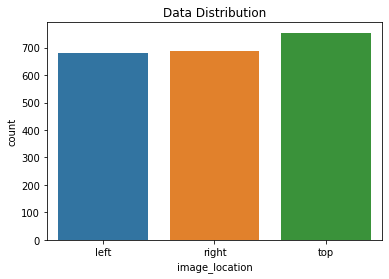

In [5]:
sns.countplot(x='image_location',data=train_data).set_title("Data Distribution")

In [6]:
test_data

,image_id,image_location
0,ID_6NEDKOYZ.JPG,right
1,ID_57QZ4S9N.JPG,top
2,ID_OCGGJS5X.JPG,top
3,ID_R2993S3S.JPG,top
4,ID_2E011NB0.JPG,top
...,...,...
483,ID_0RVNUKK1.JPG,left
484,ID_6405IKG3.JPG,left
485,ID_6WVPVB7S.JPG,top
486,ID_47C5LL2G.JPG,left


Text(0.5, 1.0, 'Data Distribution')

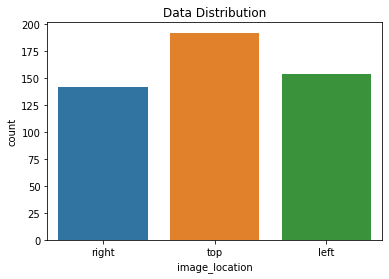

In [7]:
sns.countplot(x='image_location',data=test_data).set_title("Data Distribution")

In [8]:
train_data['image_location'].unique()

array(['left', 'right', 'top'], dtype=object)

## Define parameters

In [9]:
#Get unique_turtle_ids from train.csv
unique_turtle_ids = list(train_data['turtle_id'].unique())
#Add category for new turtle for test set
unique_turtle_ids.append("new_turtle")
#Get number of images for train/test split
split = 0.9
lines = round(len(train_data)*split)
length_data = len(train_data)

#We set some parameters for the model
HEIGHT = 224 #image height
WIDTH = 224 #image width
CHANNELS = 3 #image RGB channels
CLASS_NAMES = list(train_data['image_location'].unique())
NCLASSES = 3
BATCH_SIZE = 32
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

TRAINING_SIZE = lines
VALIDATION_SIZE = length_data - lines                    
VALIDATION_STEPS = VALIDATION_SIZE // BATCH_SIZE

## Pre-processing

In [10]:
def preprocess(augment = True):
    if augment == True:
        train_datagen = ImageDataGenerator(
                rotation_range     = 40,
                width_shift_range  = 0.2,
                height_shift_range = 0.2,
                rescale            = 1./255,
                shear_range        = 0.2,
                zoom_range         = 0.2,
                horizontal_flip    = False,
                fill_mode          = 'nearest')

        test_datagen = ImageDataGenerator(rescale=1./255)
    
    else:
        train_datagen = ImageDataGenerator(rescale=1./255)
        test_datagen  = ImageDataGenerator(rescale=1./255)
        
    return train_datagen, test_datagen

In [11]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
#x_col value : which will be the name of column(in dataframe) having file names
#y_col value : which will be the name of column(in dataframe) having class/label

def use_image_generator(train_datagen, test_datagen, training=True): 
    
    if training == True:
        # Augment and scale images for training
        train_generator = train_datagen.flow_from_dataframe(dataframe =train_data[0:lines], 
                directory   = image_dir,
                x_col       = "image_id" ,
                y_col       = "image_location",
                target_size = (HEIGHT, WIDTH),
                batch_size  = BATCH_SIZE,
                classes     = CLASS_NAMES,
                class_mode  = 'categorical',
                shuffle     = False)
                #save_to_dir="output/",  if you wanna save the cropped images
                #save_prefix="",
                #save_format='png')

        # Scale images for validation
        validation_generator = test_datagen.flow_from_dataframe(dataframe = train_data[lines:], 
                directory    = image_dir,
                x_col        = "image_id",
                y_col        = "image_location",
                target_size  = (HEIGHT, WIDTH),
                batch_size   = BATCH_SIZE,
                classes      = CLASS_NAMES,
                class_mode   = 'categorical',
                shuffle      = False)
        
        return train_generator, validation_generator
    
    else:
        # Scale images for testing, no target provided and returned
        test_generator = test_datagen.flow_from_dataframe(dataframe = test_data, 
                directory   = image_dir,
                x_col       = "image_id",
                y_col        = "image_location",                                          
                target_size = (HEIGHT, WIDTH),
                batch_size  = BATCH_SIZE,
                classes      = CLASS_NAMES,                                          
                class_mode  = 'categorical',
                shuffle     = False)
            
        return test_generator


## Create model and train

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets, layers, models

Metal device set to: Apple M1


In [13]:
#change the last layer
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final softmax layer with 101 nodes for classification output
x = layers.Dense(NCLASSES, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(1e-5), loss = 'binary_crossentropy', metrics = 'accuracy')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
train_datagen, test_datagen = preprocess()
train_generator, validation_generator = use_image_generator(train_datagen, test_datagen, training=True)
    
inception =  model.fit(
        train_generator, 
        validation_data=validation_generator,
        steps_per_epoch=TRAINING_SIZE // 32, 
        epochs=15,
        callbacks=[tensorboard_callback])

Found 1910 validated image filenames belonging to 3 classes.
Found 212 validated image filenames belonging to 3 classes.


2022-02-09 11:37:49.023710: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15
59/59 [==============================] - 52s 843ms/step - loss: 0.4041 - accuracy: 0.7423 - val_loss: 0.2188 - val_accuracy: 0.8821
Epoch 2/15
59/59 [==============================] - 47s 795ms/step - loss: 0.2487 - accuracy: 0.8573 - val_loss: 0.2067 - val_accuracy: 0.8774
Epoch 3/15
59/59 [==============================] - 47s 795ms/step - loss: 0.2176 - accuracy: 0.8834 - val_loss: 0.1725 - val_accuracy: 0.9292
Epoch 4/15
59/59 [==============================] - 48s 806ms/step - loss: 0.1845 - accuracy: 0.9073 - val_loss: 0.1910 - val_accuracy: 0.8915
Epoch 5/15
59/59 [==============================] - 49s 825ms/step - loss: 0.1602 - accuracy: 0.9239 - val_loss: 0.1691 - val_accuracy: 0.9104
Epoch 6/15
59/59 [==============================] - 49s 831ms/step - loss: 0.1695 - accuracy: 0.9095 - val_loss: 0.2069 - val_accuracy: 0.8962
Epoch 7/15
59/59 [==============================] - 50s 843ms/step - loss: 0.1544 - accuracy: 0.9148 - val_loss: 0.1632 - val_accuracy: 0.9292

## Check confusion matrix & auc_score on test data with corrected image location

In [14]:
train_datagen, test_datagen = preprocess(augment = False)
test_generator = use_image_generator(train_datagen, test_datagen, training=False)

Found 488 validated image filenames belonging to 3 classes.


In [15]:
#Get probabilities for all turtle id's
y_preds = model.predict(test_generator)
#Get index of highest prediction
y_preds = np.argmax(y_preds, axis=1)

In [16]:
print(accuracy_score(test_generator.classes, y_preds))
print(confusion_matrix(test_generator.classes, y_preds))

0.9036885245901639
[[153   1   0]
 [  4 133   5]
 [ 24  13 155]]


In [17]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(['left', 'top', 'right']):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

0.9327052039193536

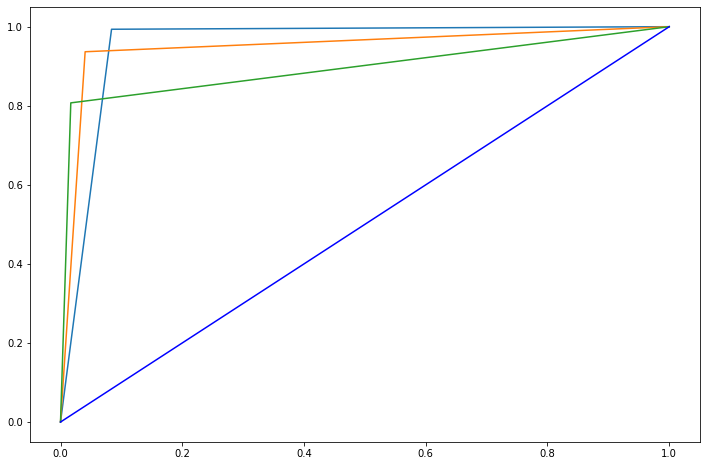

In [18]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
multiclass_roc_auc_score(test_generator.classes, y_preds)

## Create image location on extra images with trained model

In [19]:
extra = pd.read_csv('../data/extra_images.csv')
extra.image_id = extra.image_id.apply(lambda x: x.strip()+".JPG")

In [20]:
extra

,image_id,turtle_id
0,ID_Y0KYE5XD.JPG,t_id_he7JTQxO
1,ID_8JTIQ4UI.JPG,t_id_he7JTQxO
2,ID_LSXPZYSN.JPG,t_id_he7JTQxO
3,ID_SHZ2HDSP.JPG,t_id_he7JTQxO
4,ID_6TOFB06E.JPG,t_id_xry0Yg2j
...,...,...
10653,ID_PLYDY39S.JPG,t_id_9YXAIhtI
10654,ID_1EJCP0DF.JPG,t_id_9YXAIhtI
10655,ID_WXIGYROR.JPG,t_id_ajlHbN2F
10656,ID_UAU4GUNK.JPG,t_id_ajlHbN2F


In [21]:
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
#x_col value : which will be the name of column(in dataframe) having file names
#y_col value : which will be the name of column(in dataframe) having class/label

def use_image_generator_extra(train_datagen, test_datagen, training=True): 
    
    if training == True:
        # Augment and scale images for training
        train_generator = train_datagen.flow_from_dataframe(dataframe =train_data[0:lines], 
                directory   = image_dir,
                x_col       = "image_id" ,
                y_col       = "image_location",
                target_size = (HEIGHT, WIDTH),
                batch_size  = BATCH_SIZE,
                classes     = CLASS_NAMES,
                class_mode  = 'categorical',
                shuffle     = False)
                #save_to_dir="output/",  if you wanna save the cropped images
                #save_prefix="",
                #save_format='png')

        # Scale images for validation
        validation_generator = test_datagen.flow_from_dataframe(dataframe = train_data[lines:], 
                directory    = image_dir,
                x_col        = "image_id",
                y_col        = "image_location",
                target_size  = (HEIGHT, WIDTH),
                batch_size   = BATCH_SIZE,
                classes      = CLASS_NAMES,
                class_mode   = 'categorical',
                shuffle      = False)
        
        return train_generator, validation_generator
    
    else:
        # Scale images for testing, no target provided and returned
        test_generator_extra = test_datagen.flow_from_dataframe(dataframe = extra, 
                directory   = image_dir,
                x_col       = "image_id",                                         
                target_size = (HEIGHT, WIDTH),
                batch_size  = BATCH_SIZE,                                         
                class_mode  = None,
                shuffle     = False)
            
        return test_generator_extra


In [22]:
train_datagen, test_datagen = preprocess(augment = False)
test_generator_extra = use_image_generator_extra(train_datagen, test_datagen, training=False)

Found 10658 validated image filenames.


In [23]:
#Get probabilities for all turtle id's
y_preds = model.predict(test_generator_extra)
#Get index of highest prediction
y_preds = np.argmax(y_preds, axis=1)
y_preds

array([0, 2, 0, ..., 2, 1, 0])

In [24]:
#Create a DataFrame with top prediction in extra form
list = []
for id in y_preds:
    list.append(CLASS_NAMES[id])

title = ['image_location']

image_location = pd.DataFrame(list, columns= title)

#Insert image_ids from test_data
extra = pd.read_csv('../data/extra_images.csv')
extra.insert(loc=1, column='image_location', value=image_location['image_location'])
extra

,image_id,image_location,turtle_id
0,ID_Y0KYE5XD,left,t_id_he7JTQxO
1,ID_8JTIQ4UI,top,t_id_he7JTQxO
2,ID_LSXPZYSN,left,t_id_he7JTQxO
3,ID_SHZ2HDSP,left,t_id_he7JTQxO
4,ID_6TOFB06E,top,t_id_xry0Yg2j
...,...,...,...
10653,ID_PLYDY39S,right,t_id_9YXAIhtI
10654,ID_1EJCP0DF,left,t_id_9YXAIhtI
10655,ID_WXIGYROR,top,t_id_ajlHbN2F
10656,ID_UAU4GUNK,right,t_id_ajlHbN2F


In [25]:
#Save submission data as CSV
extra.to_csv('../data/extra_images_loc.csv', index = False)

In [26]:
extra.head(50)

,image_id,image_location,turtle_id
0,ID_Y0KYE5XD,left,t_id_he7JTQxO
1,ID_8JTIQ4UI,top,t_id_he7JTQxO
2,ID_LSXPZYSN,left,t_id_he7JTQxO
3,ID_SHZ2HDSP,left,t_id_he7JTQxO
4,ID_6TOFB06E,top,t_id_xry0Yg2j
5,ID_S4UE5U6O,right,t_id_xry0Yg2j
6,ID_JJIFQ5KY,left,t_id_xry0Yg2j
7,ID_A5VJ0BYZ,right,t_id_xry0Yg2j
8,ID_2XUE5CLL,right,t_id_SwQZGIpa
9,ID_Y2OPZMDL,left,t_id_SwQZGIpa
